# ACP Project - Model Evaluation

## Setup

In [1]:
import warnings, pickle, os
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns

import shap
import optuna

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import f2_score, METRICS, evaluate, evaluate_from_pred, with_sampling_strategies, spotCheckCV, spotCheckDatasets, F2TabNet, joint_plot
from utils.isolation_forest_wrapper import IsolationForestWrapper
%aimport utils.evaluation

In [3]:
from hyperparameter_tuning import tune_xgboost, tune_tabnet, tune_lgbm, tune_randomforest, tune_isolationforest, tune_logisticregression
%aimport hyperparameter_tuning

In [4]:
class Notebook:
    IMAGE_DIR = "images/critical_event_24_missing_values"
    MODEL_DIR = "models/critical_event_24_missing_values"
    OUTCOME = "CriticalEvent"
    OUTCOME_WITHIN = 1

    SAVE_MODELS = True
    SAVE_IMAGES = False

    RUN_HYPERPARAMETERS = False
    HYPERPARAMETER_TIMEOUT = 60 * 60
    HYPERPARAMETER_NJOBS = 8

    SHAP_PLOTS_MAXDISPLAY = 20
    EVAL_N_RESAMPLES = 99

    MODELS = {}
    EXPLAINERS = {}
    EVAL_RESULTS = {}
    TUNED_RESULTS = {}
    MORTALITY_RESULTS = {}
    CRITICALCARE_RESULTS = {}


In [5]:
try:
    os.makedirs(Notebook.IMAGE_DIR)
    os.makedirs(Notebook.MODEL_DIR)
except FileExistsError:
    pass


In [6]:
def restore():
    with open(f"{Notebook.MODEL_DIR}/models.bin", "rb") as file:
        Notebook.MODELS = pickle.load(file)

    with open(f"{Notebook.MODEL_DIR}/explainers.bin", "rb") as file:
        Notebook.EXPLAINERS = pickle.load(file)


### Dataset

In [7]:
from dataset import SCIData, SCICols
from utils.data_profiling import ensure_categorical_overlap, drop_exclusive_cols
%aimport dataset, utils.data_profiling

sci = (
    SCIData.load('data/sci_processed.h5')
    .fix_readmissionband()
    .derive_critical_event(within=Notebook.OUTCOME_WITHIN, return_subcols=True)
)
Notebook.OUTCOME = 'CriticalEvent'



In [18]:
from sklearn.model_selection import train_test_split

scii = (
    SCIData(sci.sort_values('AdmissionDateTime'))
    .omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "LastSpecialty"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
)

sci_train, sci_test = train_test_split(
    scii, test_size=0.33, random_state=42, shuffle=False
)
y_test_mortality, y_test_criticalcare = (
    sci_test.DiedWithinThreshold.copy(),
    sci_test.CriticalCare.copy(),
)

if Notebook.OUTCOME == "CriticalEvent":
    sci_train, sci_test = (
        sci_train.drop(
            ["DiedWithinThreshold", "CriticalCare"], axis=1, errors="ignore"
        ),
        sci_test.drop(["DiedWithinThreshold", "CriticalCare"], axis=1, errors="ignore"),
    )

sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

# Drop HSMR_15 as there is only 1 in the entire dataset, making a split impossible
(X_train, y_train), (X_test, y_test) = (
    sci_train.impute_blood().encode_ccs_onehot().xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True
    ),
    sci_test.impute_blood().encode_ccs_onehot().xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True
    ),
)
categorical_cols_idx, categorical_cols_dims = X_train.describe_categories()
drop_exclusive_cols(X_train, X_test)
ensure_categorical_overlap(X_train, X_test, categorical_cols_idx)

# Mandated vitals, Categorical diagnoses (main only)
(X_train_if, y_train_if), (X_test_if, y_test_if) = (
    sci_train.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
    sci_test.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
)
drop_exclusive_cols(X_train_if, X_test_if)

(X_train_lgbm, y_train_lgbm), (X_test_lgbm, y_test_lgbm) = (
    sci_train.encode_ccs_onehot().xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=False),
    sci_test.encode_ccs_onehot().xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=False),
)
drop_exclusive_cols(X_train_lgbm, X_test_lgbm)
ensure_categorical_overlap(X_train_lgbm, X_test_lgbm, categorical_cols_idx)

(X_train_tn, X_valid_tn, y_train_tn, y_valid_tn) = train_test_split(
    X_train.to_numpy(),
    y_train.to_numpy(),
    stratify=y_train,
    test_size=0.33,
    random_state=42,
)

(X_train_news, y_train_news), (X_test_news, y_test_news) = (
    sci_train.xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True
    ),
    sci_test.xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True
    ),
)
drop_exclusive_cols(X_train_news, X_test_news)


### Tuning

In [9]:
from sklearn.metrics import precision_recall_curve


def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(recall - target).argmin()]

    return closest


## Models

### Baseline (NEWS)

In [ ]:
baseline_mask = sci[sci.c_NEWS_score.notna()].index.intersection(sci_test.index)
Notebook.EVAL_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news.png" if Notebook.SAVE_IMAGES else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
print("Mortality")
Notebook.MORTALITY_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test_mortality.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news_mortality.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test_criticalcare.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news_criticalcare.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)



### Logistic Regression (NEWS only)

In [ ]:
from sklearn.linear_model import LogisticRegression

modelkey = "Logistic Regression (NEWS only)"
model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42).fit(
    X_train_news, y_train_news
)
Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_news,
    y_test_news,
    plot_title="Logistic Regression (NEWS only, non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
threshold = get_threshold(y_train_news, model.predict_proba(X_train_news)[:, 1],)

y_pred_proba = model.predict_proba(X_test_news)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_news,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)



In [ ]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
explainer = shap.LinearExplainer(
    model, X_train_news, feature_perturbation="correlation_dependent"
)
shap_values = explainer(X_test_news)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression (NEWS only)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression_news.png",
        bbox_inches="tight",
    )


In [ ]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression (NEWS only)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logistic_regression_news.png",
        bbox_inches="tight",
    )


### Logistic Regression

In [ ]:
lr_params = {
    "LR__max_iter": 10000,
    "LR__penalty": "l2",
    "LR__solver": "lbfgs",
    "LR__C": 7.87,
    "LR__class_weight": "balanced",
    "IMB__sampling_strategy": 0.2,
}

if Notebook.RUN_HYPERPARAMETERS:
    lr_params.update(tune_logisticregression(
        X_train, y_train, timeout=Notebook.HYPERPARAMETER_TIMEOUT, n_jobs=Notebook.HYPERPARAMETER_NJOBS
    ))


In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "Logistic Regression"
model = (
    ImbPipeline(
        steps=[
            ("IMB", RandomUnderSampler()),
            ("LR", LogisticRegression()),
        ]
    )
    .set_params(**lr_params)
    .fit(X_train, y_train)
)

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test,
    y_test,
    plot_title="Logistic Regression (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)

Notebook.MODELS[modelkey] = model


In [ ]:
threshold = get_threshold(y_train, model.predict_proba(X_train)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
explainer = shap.LinearExplainer(
    model["LR"], X_train, feature_perturbation="correlation_dependent"
)
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression.png", bbox_inches="tight"
    )


In [ ]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logistic_regression.png", bbox_inches="tight"
    )


### Random Forest

In [ ]:
rf_params = {
    "RF__n_estimators": 250,
    "RF__max_features": 0.56,
    "RF__min_samples_split": 8,
    "RF__min_samples_leaf": 3,
    "RF__max_samples": 0.75,
    "RF__class_weight": "balanced",
    "IMB__sampling_strategy": 0.14,
}

if Notebook.RUN_HYPERPARAMETERS:
    rf_params.update(tune_randomforest(
        X_train, y_train, timeout=Notebook.HYPERPARAMETER_TIMEOUT, n_jobs=Notebook.HYPERPARAMETER_NJOBS
    ))



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "Random Forest"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("RF", RandomForestClassifier())])
    .set_params(**rf_params)
    .fit(X_train.to_numpy(), y_train)
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test.to_numpy(),
    y_test,
    plot_title="Random Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)



In [ ]:
threshold = get_threshold(y_train, model.predict_proba(X_train.to_numpy())[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > 1 - threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
explainer = shap.TreeExplainer(model["RF"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Random Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_random_forest.png", bbox_inches="tight"
    )


In [ ]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Random Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_random_forest.png", bbox_inches="tight")


### XGBoost

In [ ]:
xgboost_params = {
    "XGB__verbosity": 0,
    "XGB__n_jobs": 1,
    "XGB__missing": -1,
    "XGB__objective": "binary:logistic",
    "XGB__enable_categorical": True,
    "XGB__tree_method": "hist",
    "XGB__missing": -1,
    "XGB__booster": "gbtree",
    "XGB__lambda": 7e-2,
    "XGB__alpha": 7e-05,
    "XGB__subsample": 0.42,
    "XGB__colsample_bytree": 0.87,
    "XGB__scale_pos_weight": 14,
    "XGB__max_depth": 7,
    "XGB__min_child_weight": 10,
    "XGB__eta": 0.034,
    "XGB__gamma": 4e-08,
    "XGB__grow_policy": "lossguide",
    "IMB__sampling_strategy": 0.1,
}



if Notebook.RUN_HYPERPARAMETERS:
    xgboost_params.update(tune_xgboost(
        X_train_lgbm, y_train_lgbm, timeout=Notebook.HYPERPARAMETER_TIMEOUT, n_jobs=Notebook.HYPERPARAMETER_NJOBS
    ))



In [ ]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "XGBoost"
model = (
    ImbPipeline(
        steps=[
            ("IMB", RandomUnderSampler()),
            ("XGB", XGBClassifier()),
        ]
    )
    .set_params(**xgboost_params)
    .fit(X_train_lgbm, y_train_lgbm)
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_lgbm,
    y_test_lgbm,
    "XGBoost (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_xgboost.png" if Notebook.SAVE_IMAGES else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
threshold = get_threshold(y_train_lgbm, model.predict_proba(X_train_lgbm)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > 1 - threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
sorted_idx = model["XGB"].feature_importances_.argsort()[::-1]
fig = sns.barplot(
    x=model["XGB"].feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
)
fig.set_title("XGBoost - Global feature importance (gain)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_xgboost.png", bbox_inches="tight")



In [ ]:
explainer = shap.TreeExplainer(model["XGB"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("XGBoost")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_xgboost.png", bbox_inches="tight")


In [ ]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("XGBoost")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_xgboost.png", bbox_inches="tight")


### LightGBM

In [10]:
lgbm_params = {
    'LGBM__objective': "binary",
    'LGBM__metrics': ["l2", "auc"],
    "LGBM__boosting_type": "gbdt",
    "LGBM__is_unbalance": True,
    "LGBM__n_jobs": 1,
    "LGBM__feature_pre_filter": False,
    "LGBM__lambda_l1": 0.15,
    "LGBM__lambda_l2": 3.2,
    "LGBM__num_leaves": 225,
    "LGBM__feature_fraction": 0.8,
    "LGBM__bagging_fraction": 0.8,
    "LGBM__bagging_freq": 7,
    "LGBM__min_child_samples": 45,
    "IMB__sampling_strategy": 0.1
}

if Notebook.RUN_HYPERPARAMETERS:
    lgbm_params.update(tune_lgbm(
        X_train_lgbm, y_train_lgbm, categorical_cols_idx, timeout=Notebook.HYPERPARAMETER_TIMEOUT, n_jobs=Notebook.HYPERPARAMETER_NJOBS
    ))


Using categorical_feature in Dataset.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Model,0.962176,0.124242,0.75576,0.213403,0.374771,0.939762,0.923-0.953


array([[30591,  1156],
       [   53,   164]], dtype=int64)

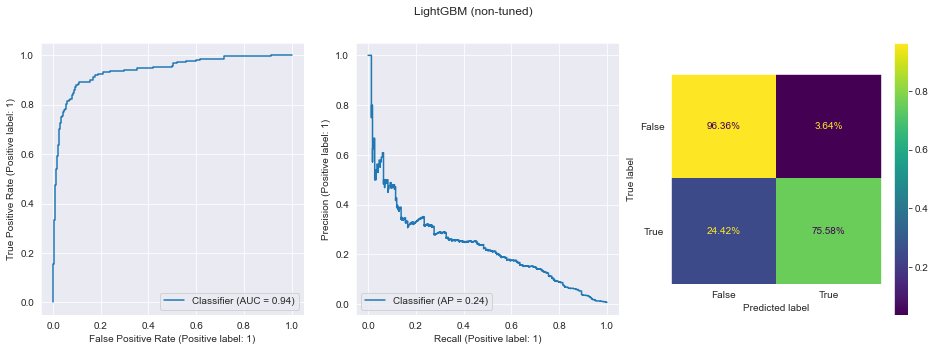

In [24]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "LightGBM"

model = (
    ImbPipeline(
        steps=[
            ("IMB", RandomUnderSampler()),
            ("LGBM", LGBMClassifier()),
        ]
    )
    .set_params(**lgbm_params)
    .fit(X_train_lgbm, y_train_lgbm, LGBM__categorical_feature=categorical_cols_idx, LGBM__feature_name=list(X_train.columns))
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_lgbm,
    y_test_lgbm,
    plot_title="LightGBM (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_lightgbm.png" if Notebook.SAVE_IMAGES else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Model,0.913528,0.063122,0.847926,0.117497,0.243193,0.939762,0.923-0.953


array([[29016,  2731],
       [   33,   184]], dtype=int64)

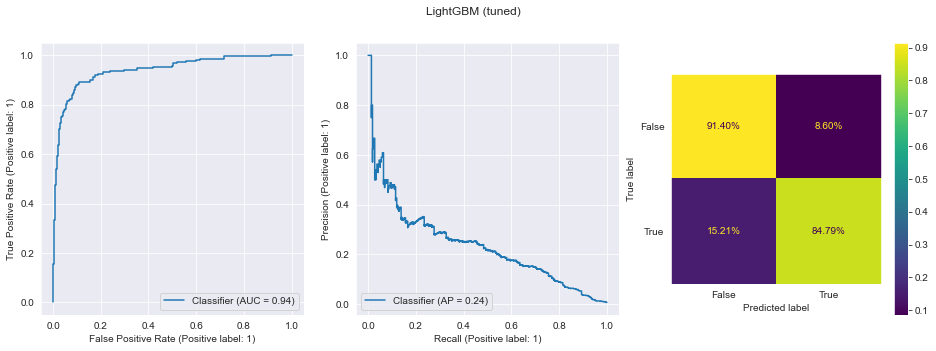

In [25]:
threshold = get_threshold(y_test_lgbm, model.predict_proba(X_test_lgbm)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
import lightgbm as lgb

fig = lgb.plot_importance(model['LGBM'], figsize=(10,10))
fig.set_title("LightGBM - Global feature importance (gain)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/global_weights_lightgbm.png", bbox_inches="tight"
    )


In [ ]:
explainer = shap.TreeExplainer(model['LGBM'])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")
if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_lightgbm.png", bbox_inches="tight")


In [ ]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_lightgbm.png", bbox_inches="tight")


### Isolation Forest

In [ ]:
if_params = {
    "n_estimators": 140,
    "max_samples": 0.465,
    "contamination": 0.0213,
    "max_features": 0.69,
    "bootstrap": False,
}

if Notebook.RUN_HYPERPARAMETERS:
    if_params = tune_isolationforest(
        X_train_if, y_train_if, timeout=Notebook.HYPERPARAMETER_TIMEOUT, n_jobs=Notebook.HYPERPARAMETER_NJOBS
    )



In [ ]:
modelkey = "Isolation Forest"

model = IsolationForestWrapper(**if_params).fit(X_train_if[~y_train_if].to_numpy())
Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_if.to_numpy(),
    y_test_if,
    plot_title="Isolation Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
y_pred_proba_train = model.decision_function(X_train_if)
y_pred_proba_train -= y_pred_proba_train.min()

threshold = get_threshold(y_train_if, y_pred_proba_train,)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.decision_function(X_test_if)
y_pred = np.where(y_pred_proba - y_pred_proba.min() > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_if,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_if)
shap_values.values = -shap_values.values  # Fix for isolation forest's unique labelling
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_isolation_forest.png", bbox_inches="tight"
    )



In [ ]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_isolation_forest.png", bbox_inches="tight"
    )



### TabNet

In [ ]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_params = dict(
    cat_idxs=categorical_cols_idx,
    cat_dims=categorical_cols_dims,
    n_a=64,
    n_d=64,
    n_steps=3,
    gamma=1.0,
    lambda_sparse=9e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.02, weight_decay=1e-05),
    mask_type="sparsemax",
    n_shared=1,
    scheduler_params=dict(mode="min", patience=5, min_lr=1e-05, factor=0.5,),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    verbose=1,
)
tabnet_epochs, tabnet_patience = 100, 50

if Notebook.RUN_HYPERPARAMETERS:
    tabnet_params, tabnet_epochs, tabnet_patience = tune_tabnet(
        X_train,
        y_train,
        categorical_cols_idx,
        categorical_cols_dims,
        timeout=Notebook.HYPERPARAMETER_TIMEOUT,
        n_jobs=Notebook.HYPERPARAMETER_NJOBS
    )


In [ ]:
modelkey = "TabNet"
model = TabNetClassifier(**tabnet_params)
model.fit(
    X_train=X_train_tn,
    y_train=y_train_tn,
    eval_set=[(X_train_tn, y_train_tn), (X_valid_tn, y_valid_tn)],
    eval_name=["train", "valid"],
    eval_metric=['auc'],
    max_epochs=tabnet_epochs,
    patience=tabnet_patience,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test.to_numpy(),
    y_test,
    "TabNet (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_tabnet.png" if Notebook.SAVE_IMAGES else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
threshold = get_threshold(
    y_test, model.predict_proba(X_test.to_numpy())[:, 1], target=0.785
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
)


In [ ]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples = Notebook.EVAL_N_RESAMPLES
)


In [ ]:
sorted_idx = model.feature_importances_.argsort()[::-1]
fig = sns.barplot(
    x=model.feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
)
fig.set_title("TabNet - Global feature importance")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_tabnet.png", bbox_inches="tight")



In [ ]:
X_test_tn_shap = shap.sample(X_test.to_numpy(), 5000)
explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train_tn, 100))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_test_tn_shap, nsamples=50)

Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

shap.summary_plot(
    shap_values[1],
    X_test_tn_shap,
    feature_names=X_test.columns,
    show=False,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    plot_type="dot",
)
plt.title("TabNet (estimated)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_tabnet.png", bbox_inches="tight")


In [ ]:
shap.summary_plot(
    shap_values[1],
    X_test_tn_shap,
    feature_names=X_test.columns,
    show=False,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    plot_type="bar",
    color=shap.plots.colors.red_rgb,
)
plt.title("TabNet (estimated)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_tabnet.png", bbox_inches="tight")


In [ ]:
if Notebook.SAVE_MODELS:
    with open(f"{Notebook.MODEL_DIR}/models.bin", "wb") as file:
        pickle.dump(Notebook.MODELS, file)

    with open(f"{Notebook.MODEL_DIR}/explainers.bin", "wb") as file:
        pickle.dump(Notebook.EXPLAINERS, file)


## Comparisons

### Scores

#### Pre-tuning scores

In [ ]:
pd.concat(
    [results[0].assign(Model=key) for key, results in Notebook.EVAL_RESULTS.items()]
).set_index("Model")



#### Post-tuning scores

In [ ]:
pd.concat(
    [results[0].assign(Model=key) for key, results in Notebook.TUNED_RESULTS.items()]
).set_index("Model")



### ROC

In [ ]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.EVAL_RESULTS.items()},
    {key: val[2] for key, val in Notebook.EVAL_RESULTS.items()},
)



In [ ]:
joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (ROC)",
)


### Precision-Recall

In [ ]:
joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall",
    legend_location="upper right",
)


### Side-by-side

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict,
    ax=ax[1],
    title="Precision-Recall",
    legend_location="upper right",
    plot_baseline=False,
)
joint_plot(
    roc_dict,
    ax=ax[0],
    title="Receiver Operating Characteristic (ROC)",
    plot_baseline=False,
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_no_baseline.png", bbox_inches="tight"
    )



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/combined_curves.png", bbox_inches="tight")


### SHAP Explanations (Setup - skip to next section)

In [ ]:
y_preds = pd.DataFrame(
    {
        key: model.predict(
            {
                "LightGBM": X_test,
                "Isolation Forest": X_test_if,
                "TabNet": X_test.to_numpy(),
                "XGBoost": X_test,
                "Random Forest": X_test,
                "Logistic Regression": X_test,
            }[key]
        )
        for key, model in Notebook.MODELS.items()
        if key != "Logistic Regression (NEWS only)"
    }
)

candidates = y_preds[y_preds.all(axis=1)].index

patient = candidates[0]
patient_data = X_test.iloc[patient].apply(
    lambda x: f"{x:.2f}" if type(x) == np.float64 else x
)
patient_data_if = X_test_if.iloc[patient].copy()
patient_data_if.update(X_test.iloc[patient])

explanations = {
    modelkey: shap_values[patient]
    for modelkey, (_, shap_values) in Notebook.EXPLAINERS.items()
    if not modelkey in ["TabNet", "Logistic Regression (NEWS only)"]
}
for _ in explanations.keys():
    if len(explanations[_].shape) > 1:
        explanations[_] = explanations[_][:, 1]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    tabnet_explainer = Notebook.EXPLAINERS["TabNet"][0]
    explanations["TabNet"] = shap.Explanation(
        tabnet_explainer.shap_values(X_test.to_numpy()[patient])[1],
        data=patient_data.values,
        base_values=tabnet_explainer.expected_value[1],
        feature_names=patient_data.index,
    )



### SHAP Force Plots

In [ ]:
sns.set_style("white")
plt.rc("axes", titlesize=16)
for modelkey, explanation in explanations.items():
    patient_to_use = patient_data if modelkey != "Isolation Forest" else patient_data_if

    explanation = shap.Explanation(explanation)
    explanation.data = patient_to_use.values

    fig = shap.plots.force(
        explanation,
        feature_names=patient_to_use.index,
        matplotlib=True,
        contribution_threshold=0.08,
        show=False,
        text_rotation=15,
    )

    plt.title(modelkey)
    display(fig)

    if Notebook.SAVE_IMAGES:
        plt.savefig(
            f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
            bbox_inches="tight",
        )

    plt.clf()

sns.set_style("darkgrid")



### Mortality-only Results

In [ ]:
pd.concat(
    [
        results[0].assign(Model=key)
        for key, results in Notebook.MORTALITY_RESULTS.items()
    ]
).set_index("Model")



In [ ]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.MORTALITY_RESULTS.items()},
    {key: val[2] for key, val in Notebook.MORTALITY_RESULTS.items()},
)

joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve_mortality"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (predicting mortality only)",
)

joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve_mortality"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall (predicting mortality only)",
    legend_location="upper right",
)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_mortality.png", bbox_inches="tight"
    )


### Critical care-only results

In [ ]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.CRITICALCARE_RESULTS.items()},
    {key: val[2] for key, val in Notebook.CRITICALCARE_RESULTS.items()},
)

joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve_criticalcare"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (predicting critical care only)",
)

joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve_criticalcare"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall (predicting critical care only)",
    legend_location="upper right",
)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_criticalcare.png", bbox_inches="tight"
    )
